In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [ ]:
DATA_DIRECTORY = 'content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets, BATCH_SIZE):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.alexnet(pretrained=False)
    for param in model.parameters():
        param.requires_grad = True  # Set requires_grad to True for fine-tuning
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)  # Adding a new layer for classification
    )
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        if val_acc_history[-1] > best_acc:
            best_acc = val_acc_history[-1]

    print('Best validation Acc: {:4f}'.format(best_acc))

    plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

In [ ]:
def train(num_epochs, model, train_loader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)

    total_steps = len(train_loader)
    losses = 0
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):

        losses = 0
        total = 0
        correct = 0

        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            losses += loss.item()

            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Train accuracy
            total += labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        mean_loss_epoch = losses/total_steps
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, mean_loss_epoch,
                    (correct / total) * 100))


        train_loss.append(mean_loss_epoch)
        train_accuracy.append((correct / total) * 100)

    return train_loss, train_accuracy, model

In [ ]:
train_loss_hyper_paramaters = {}
train_acc_hyper_paramaters = {}
hyper_parameters= {"batch_size":[8, 16, 32, 64, 128]}
num_epochs = 10
learning_rate = 0.001

for batch_size in hyper_parameters["batch_size"]:
    print(f'Results of the batch size = {batch_size}')
    image_datasets = load_datasets()
    dataloaders = create_dataloaders(image_datasets, batch_size)
    train_loader, test_loader = dataloaders['train'], dataloaders['test']

    ############### Define model, criterion, optimizer, and learning rate scheduler here ##############
    model = setup_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ############ Call the train function ###########
    train_loss, train_accuracy, model = train(num_epochs, model, train_loader, criterion, optimizer)

    ############ Store train_loss, and train_accuracy in the defined dictionaries ###########

    train_loss_hyper_paramaters[f"b{batch_size}"] = train_loss
    train_acc_hyper_paramaters[f"b{batch_size}"] = train_accuracy



Results of the batch size = 8
Device: cuda:0
Epoch [1/10], Loss: 2.3666, Accuracy: 14.43%
Epoch [2/10], Loss: 2.1465, Accuracy: 22.97%
Epoch [3/10], Loss: 1.9873, Accuracy: 28.46%
Epoch [4/10], Loss: 1.9549, Accuracy: 30.04%
Epoch [5/10], Loss: 1.7955, Accuracy: 35.83%
Epoch [6/10], Loss: 1.9503, Accuracy: 32.59%
Epoch [7/10], Loss: 1.8371, Accuracy: 35.21%
Epoch [8/10], Loss: 1.8189, Accuracy: 36.71%
Epoch [9/10], Loss: 1.7958, Accuracy: 37.27%
Epoch [10/10], Loss: 1.7828, Accuracy: 37.21%
Results of the batch size = 16
Device: cuda:0
Epoch [1/10], Loss: 2.2024, Accuracy: 19.35%
Epoch [2/10], Loss: 1.9094, Accuracy: 29.53%
Epoch [3/10], Loss: 1.8208, Accuracy: 34.11%
Epoch [4/10], Loss: 1.7290, Accuracy: 39.75%
Epoch [5/10], Loss: 1.6586, Accuracy: 43.22%
Epoch [6/10], Loss: 1.6259, Accuracy: 44.17%
Epoch [7/10], Loss: 1.6352, Accuracy: 44.73%
Epoch [8/10], Loss: 1.5917, Accuracy: 45.84%
Epoch [9/10], Loss: 1.5672, Accuracy: 46.87%
Epoch [10/10], Loss: 1.5495, Accuracy: 47.31%
Results

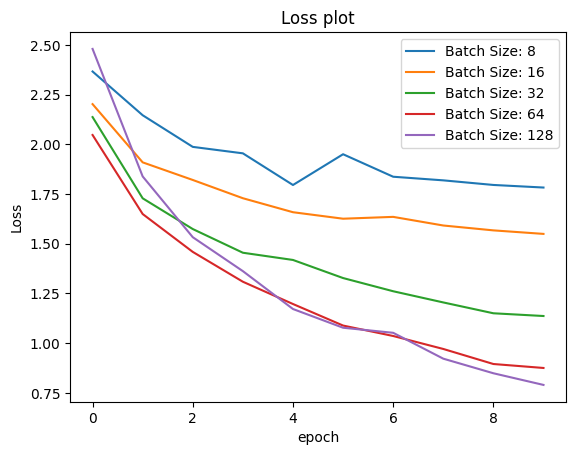

In [ ]:
####### plot the the training loss here #########

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs,train_loss_hyper_paramaters[f'b{batch_size}'],label=f'Batch Size: {batch_size}')

plt.legend()

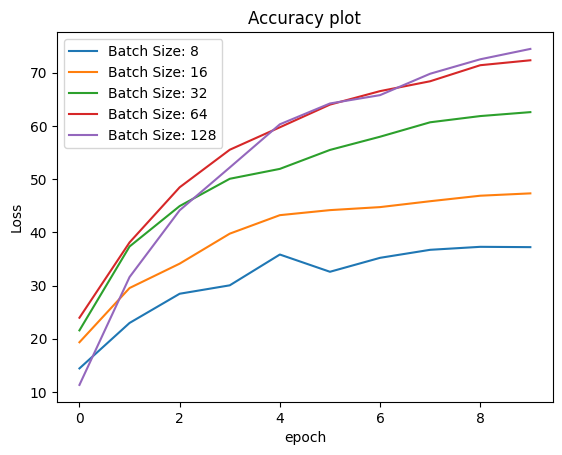

In [ ]:
####### plot the the training accuracies here #########

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Accuracy plot')

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(epochs,train_acc_hyper_paramaters[f'b{batch_size}'],label=f'Batch Size: {batch_size}')

plt.legend()